# DFS and BFS for Maze Solving

## Step 1: Understanding the Maze Format

A maze is represented as a text file with the following characters:
- `#` → Wall (cannot pass through)
- ` ` (space) → Open path (can walk here)
- `A` → Start position
- `B` → Goal position

Let's first look at a simple maze file to understand the format.

In [134]:
# Read and display maze1.txt
with open("src0/maze1.txt") as f:
    maze_content = f.read()

print(maze_content)

#####B#
##### #
####  #
#### ##
     ##
A######



### Understanding the Output

```
#####B#   ← Row 0: Goal 'B' is at position (0, 5)
##### #   ← Row 1: Open path at (1, 5)
####  #   ← Row 2: Open paths at (2, 4) and (2, 5)
#### ##   ← Row 3: Open path at (3, 4)
     ##   ← Row 4: Open paths at (4, 0) through (4, 4)
A######   ← Row 5: Start 'A' is at position (5, 0)
```

**Key observations:**
- The maze is a **grid** with rows and columns
- Position is represented as `(row, col)` starting from `(0, 0)` at top-left
- Start `A` is at bottom-left: `(5, 0)`
- Goal `B` is at top-right area: `(0, 5)`
- We need to find a path from A to B avoiding walls (`#`)

## Step 2: Parsing the Maze

Now we need to extract useful information from the maze text:
1. **Height** - number of rows
2. **Width** - number of columns  
3. **Start position** - where is 'A'?
4. **Goal position** - where is 'B'?
5. **Walls grid** - which cells are walls?

Let's do this step by step.

In [135]:
# Step 2a: Split into lines and get dimensions
lines = maze_content.splitlines()

print("Lines in the maze:")
for i, line in enumerate(lines):
    print(f"  Row {i}: '{line}'")

Lines in the maze:
  Row 0: '#####B#'
  Row 1: '##### #'
  Row 2: '####  #'
  Row 3: '#### ##'
  Row 4: '     ##'
  Row 5: 'A######'


In [136]:
# Step 2b: Calculate height and width
height = len(lines)
width = max(len(line) for line in lines)

print(f"Height (number of rows): {height}")
print(f"Width (number of columns): {width}")

Height (number of rows): 6
Width (number of columns): 7


In [137]:
# Step 2c: Find start (A) and goal (B) positions
start = None
goal = None

for i in range(height):
    for j in range(len(lines[i])):
        if lines[i][j] == "A":
            start = (i, j)
        elif lines[i][j] == "B":
            goal = (i, j)

print(f"Start position (A): {start}")
print(f"Goal position (B): {goal}")

Start position (A): (5, 0)
Goal position (B): (0, 5)


In [138]:
# Step 2d: Create walls grid
# True = wall (cannot pass), False = open path (can walk)

walls = []
for i in range(height):
    row = []
    for j in range(width):
        # Handle case where line might be shorter than width
        if j >= len(lines[i]):
            row.append(False)  # Treat as open
        elif lines[i][j] == "#":
            row.append(True)   # Wall
        else:
            row.append(False)  # Open path (includes A, B, and spaces)
    walls.append(row)

print("Walls grid (True=wall, False=open):")
for i, row in enumerate(walls):
    print(f"  Row {i}: {row}")

Walls grid (True=wall, False=open):
  Row 0: [True, True, True, True, True, False, True]
  Row 1: [True, True, True, True, True, False, True]
  Row 2: [True, True, True, True, False, False, True]
  Row 3: [True, True, True, True, False, True, True]
  Row 4: [False, False, False, False, False, True, True]
  Row 5: [False, True, True, True, True, True, True]


In [139]:
# Step 2e: Visualize the parsed maze
print("Parsed Maze Visualization:")
print(f"Dimensions: {height} x {width}")
print(f"Start: {start}, Goal: {goal}")
print()

for i in range(height):
    for j in range(width):
        if (i, j) == start:
            print("A", end="")
        elif (i, j) == goal:
            print("B", end="")
        elif walls[i][j]:
            print("#", end="")
        else:
            print(" ", end="")
    print()  # New line after each row

Parsed Maze Visualization:
Dimensions: 6 x 7
Start: (5, 0), Goal: (0, 5)

#####B#
##### #
####  #
#### ##
     ##
A######


### Step 2 Summary

We now have all the parsed data we need:
- `height`, `width` - dimensions of the maze
- `start` - tuple `(row, col)` for starting position A
- `goal` - tuple `(row, col)` for goal position B  
- `walls` - 2D list where `walls[row][col]` is `True` if wall, `False` if open

**Next:** We need to understand how to move in the maze - what are valid actions from any position?

## Step 3: States, Actions, and Neighbors

**Key Concepts:**
- **State** = A position in the maze, represented as `(row, col)`
- **Action** = A movement direction: `"up"`, `"down"`, `"left"`, `"right"`
- **Neighbors** = Valid states we can reach from current state (not walls, not outside maze)

Let's understand how movement works in our grid:

In [140]:
# Step 3a: Understanding movement in a grid
# 
# In our coordinate system:
#   - Row increases going DOWN
#   - Column increases going RIGHT
#
#                  col 0   col 1   col 2   col 3   col 4
#                    ↓       ↓       ↓       ↓       ↓
#   row 0  →       (0,0)   (0,1)   (0,2)   (0,3)   (0,4)
#   row 1  →       (1,0)   (1,1)   (1,2)   (1,3)   (1,4)    ← UP goes here
#   row 2  →       (2,0)   (2,1)   (2,2)   (2,3)   (2,4)    ← LEFT | CURRENT | RIGHT
#   row 3  →       (3,0)   (3,1)   (3,2)   (3,3)   (3,4)    ← DOWN goes here
#   row 4  →       (4,0)   (4,1)   (4,2)   (4,3)   (4,4)
#
# Example: Current position (2, 3)
#                           (1,3)         ← UP
#                             ↑
#              (2,2)  ←  [ (2,3) ]  →  (2,4)
#             LEFT        CURRENT       RIGHT
#                             ↓
#                           (3,3)         ← DOWN

current_pos = (2, 3)  # Example position
row, col = current_pos

print(f"Current position: {current_pos}")
print()
print("Possible moves:")

print(f"  UP    → (row-1, col) = ({row}-1, {col}) = ({row-1}, {col})")
print(f"  DOWN  → (row+1, col) = ({row}+1, {col}) = ({row+1}, {col})")
print(f"  LEFT  → (row, col-1) = ({row}, {col}-1) = ({row}, {col-1})")
print(f"  RIGHT → (row, col+1) = ({row}, {col}+1) = ({row}, {col+1})")

Current position: (2, 3)

Possible moves:
  UP    → (row-1, col) = (2-1, 3) = (1, 3)
  DOWN  → (row+1, col) = (2+1, 3) = (3, 3)
  LEFT  → (row, col-1) = (2, 3-1) = (2, 2)
  RIGHT → (row, col+1) = (2, 3+1) = (2, 4)


### Step 3b: Validating Moves

Not every move is valid! Before we can move to a new position, we need to check:

1. **Bounds check:** Is the position inside the maze?
   - Row must be: `0 <= row < height`
   - Column must be: `0 <= col < width`

2. **Wall check:** Is the position walkable (not a wall)?
   - `walls[row][col]` must be `False`

```
Example: From position (0, 5) - the goal position B

  Can we go UP?    → (-1, 5) → INVALID (row < 0, outside maze)
  Can we go DOWN?  → (1, 5)  → VALID (inside maze, not a wall)
  Can we go LEFT?  → (0, 4)  → INVALID (it's a wall: walls[0][4] = True)
  Can we go RIGHT? → (0, 6)  → INVALID (it's a wall: walls[0][6] = True)
```
```
Walls grid (True=wall, False=open):
  Row 0: [True, True, True, True, True, False, True]
  Row 1: [True, True, True, True, True, False, True]
  Row 2: [True, True, True, True, False, False, True]
  Row 3: [True, True, True, True, False, True, True]
  Row 4: [False, False, False, False, False, True, True]
  Row 5: [False, True, True, True, True, True, True]
```
Let's write a function to check this:

In [141]:
# Step 3b: Checking if a move is valid
# A move is valid if:
#   1. The new position is inside the maze (not negative, not beyond height/width)
#   2. The new position is not a wall

def is_valid_move(r, c, height, width, walls):
    """Check if position (r, c) is a valid move."""
    # Check bounds
    if r < 0 or r >= height:
        return False
    if c < 0 or c >= width:
        return False
    # Check if wall
    if walls[r][c]:
        return False
    return True

# Test with some positions
test_positions = [(0, 5), (0, 0), (-1, 0), (5, 0), (6, 0)]
print("Testing is_valid_move:")
for pos in test_positions:
    r, c = pos
    valid = is_valid_move(r, c, height, width, walls)
    print(f"  Position {pos}: {valid}")

Testing is_valid_move:
  Position (0, 5): True
  Position (0, 0): False
  Position (-1, 0): False
  Position (5, 0): True
  Position (6, 0): False


### Step 3c: The Neighbors Function

Now we combine everything into a `neighbors()` function that answers: **"From my current position, where can I go?"**

**What is a "State"?**
- In search problems, a **state** represents a configuration of the problem
- In our maze, a state is simply a position: `(row, col)`
- Example: `state = (5, 0)` means we are at row 5, column 0 (the start position A)

**Function Inputs:**
| Parameter | Type | Description |
|-----------|------|-------------|
| `state` | tuple `(row, col)` | Current position in the maze |
| `height` | int | Number of rows in maze |
| `width` | int | Number of columns in maze |
| `walls` | 2D list | `walls[r][c] = True` if wall |

**Function Output:**
- Returns a **list of tuples**: `[(action, new_state), ...]`
- Each tuple contains:
  - `action`: string like `"up"`, `"down"`, `"left"`, `"right"`
  - `new_state`: the resulting position `(row, col)` after taking that action

**Example:**
```
neighbors((4, 2), ...) might return:
  [("up", (3, 2)), ("down", (5, 2)), ("left", (4, 1)), ("right", (4, 3))]
```

In [142]:
# Step 3c: The neighbors function
# Returns all valid (action, state) pairs from a given state

def neighbors(state, height, width, walls):
    """Get all valid neighbors from a state."""
    row, col = state
    
    # All possible moves: (action_name, new_position)
    candidates = [
        ("up", (row - 1, col)),
        ("down", (row + 1, col)),
        ("left", (row, col - 1)),
        ("right", (row, col + 1))
    ]
    
    # Filter to keep only valid moves
    result = []
    for action, (r, c) in candidates:
        if is_valid_move(r, c, height, width, walls):
            result.append((action, (r, c)))
    
    return result

# Test: What are the neighbors of the start position?
# Our initial state (where we begin the search)
initial_state = start  # start = (5, 0) was found in Step 2c

print(f"Initial state (start): {initial_state}")
neighbors_of_start = neighbors(initial_state, height, width, walls)
print(f"Neighbors of initial state:")
for action, new_state in neighbors_of_start:
    print(f"  Action '{action}' → {new_state}")

Initial state (start): (5, 0)
Neighbors of initial state:
  Action 'up' → (4, 0)


```
Walls grid (True=wall, False=open):
  Row 0: [True, True, True, True, True, False, True]
  Row 1: [True, True, True, True, True, False, True]
  Row 2: [True, True, True, True, False, False, True]
  Row 3: [True, True, True, True, False, True, True]
  Row 4: [False, False, False, False, False, True, True]
  Row 5: [False, True, True, True, True, True, True]
```

In [143]:
# Step 3d: Trace a few steps manually
# Let's see how we could explore from start towards goal

print("Manual exploration from start:")
print()

current = start
print(f"Step 0: At {current}")

# Move up from start
current = (4, 0)
print(f"Step 1: Move UP to {current}")
print(f"        Neighbors: {neighbors(current, height, width, walls)}")

# Move right
current = (4, 1)
print(f"Step 2: Move RIGHT to {current}")
print(f"        Neighbors: {neighbors(current, height, width, walls)}")

print()
print("We can keep exploring like this, but we need a systematic way!")
print("That's where DFS and BFS come in.")

Manual exploration from start:

Step 0: At (5, 0)
Step 1: Move UP to (4, 0)
        Neighbors: [('down', (5, 0)), ('right', (4, 1))]
Step 2: Move RIGHT to (4, 1)
        Neighbors: [('left', (4, 0)), ('right', (4, 2))]

We can keep exploring like this, but we need a systematic way!
That's where DFS and BFS come in.


### Step 3 Summary

We now understand:
- **State** = `(row, col)` position
- **Actions** = `"up"`, `"down"`, `"left"`, `"right"`
- **`neighbors(state)`** = returns list of `(action, new_state)` pairs for valid moves

From the start `(5, 0)`, we can only go UP to `(4, 0)`.

**Problem:** When we explore, we might visit the same state multiple times (going in circles). We need:
1. A way to **track which states we've explored**
2. A way to **remember how we got to each state** (to reconstruct the path)

**Next:** The Node concept - how to track parent and action for path reconstruction.

## Step 4: The Node Class

### Why do we need Nodes?

When we find the goal, we need to **trace back the path** to the start. But a state `(row, col)` only tells us WHERE we are, not HOW we got there.

A **Node** wraps a state with extra information:
- `state` → The current position `(row, col)`
- `parent` → The node we came FROM (so we can trace back)
- `action` → The action we took to get here (`"up"`, `"down"`, etc.)

```
Example: Path from A(5,0) to B(0,5)

Node 1: state=(5,0), parent=None,  action=None     ← Start (no parent)
   ↑ action="up"
Node 2: state=(4,0), parent=Node1, action="up"
   → action="right"  
Node 3: state=(4,1), parent=Node2, action="right"
   ↓ ...
   
When we reach goal, we follow parent pointers back to reconstruct the path!
```

```
Walls grid (True=wall, False=open):
  Row 0: [True, True, True, True, True, False, True]
  Row 1: [True, True, True, True, True, False, True]
  Row 2: [True, True, True, True, False, False, True]
  Row 3: [True, True, True, True, False, True, True]
  Row 4: [False, False, False, False, False, True, True]
  Row 5: [False, True, True, True, True, True, True]
```

In [144]:
# Step 4a: Define the Node class

class Node:
    def __init__(self, state, parent, action):
        self.state = state    # Current position (row, col)
        self.parent = parent  # The node we came from (None for start)
        self.action = action  # Action taken to reach this node (None for start)

# Create the starting node
start_node = Node(state=start, parent=None, action=None)

print("Start node created:")
print(f"  state:  {start_node.state}")
print(f"  parent: {start_node.parent}")
print(f"  action: {start_node.action}")

Start node created:
  state:  (5, 0)
  parent: None
  action: None


### Step 4b: Creating Child Nodes

**What is a Child Node?**

When we are at a node and explore its neighbors, each neighbor becomes a **child node** of the current node.

```
         Parent Node
        state=(5,0)
             |
    action="up" (the move we took)
             ↓
         Child Node
        state=(4,0)
        parent=Parent Node
        action="up"
```

**Parent-Child Relationship:**
- **Parent** → The node we are currently at
- **Child** → A new node created for each valid neighbor
- The child's `parent` attribute points back to the parent node
- The child's `action` attribute stores how we got there

This creates a **tree structure** as we explore:
```
                    (5,0) Start
                      |
                    (4,0)  ← only 1 child (only "up" is valid)
                   /    \
               (4,1)    ... 
              /    \
          (4,2)    ...
```

In [145]:
# Step 4b: Creating child nodes from neighbors

# Get neighbors of start node's state
neighbor_list = neighbors(start_node.state, height, width, walls)

print(f"From state {start_node.state}, neighbors are: {neighbor_list}")
print()

# Create a child node for each neighbor
print("Creating child nodes:")
for action, new_state in neighbor_list:
    child_node = Node(state=new_state, parent=start_node, action=action)
    print(f"  Child node:")
    print(f"    state:  {child_node.state}")
    print(f"    parent: {child_node.parent.state}")  # Show parent's state
    print(f"    action: {child_node.action}")

From state (5, 0), neighbors are: [('up', (4, 0))]

Creating child nodes:
  Child node:
    state:  (4, 0)
    parent: (5, 0)
    action: up


In [146]:
# Step 4c: Tracing back the path using parent pointers

# Let's manually create a small chain of nodes to demonstrate path reconstruction
# Simulating: start(5,0) → up(4,0) → right(4,1) → right(4,2)

node1 = Node(state=(5, 0), parent=None, action=None)        # Start
node2 = Node(state=(4, 0), parent=node1, action="up")       # After going up
node3 = Node(state=(4, 1), parent=node2, action="right")    # After going right
node4 = Node(state=(4, 2), parent=node3, action="right")    # After going right again

print("Chain of nodes created:")
print(f"  node1: {node1.state} (start)")
print(f"  node2: {node2.state} ← came from {node2.parent.state} via '{node2.action}'")
print(f"  node3: {node3.state} ← came from {node3.parent.state} via '{node3.action}'")
print(f"  node4: {node4.state} ← came from {node4.parent.state} via '{node4.action}'")

Chain of nodes created:
  node1: (5, 0) (start)
  node2: (4, 0) ← came from (5, 0) via 'up'
  node3: (4, 1) ← came from (4, 0) via 'right'
  node4: (4, 2) ← came from (4, 1) via 'right'


In [147]:
# Step 4d: Reconstructing the path by following parent pointers

# Suppose node4 is our goal - trace back to find the path
current_node = node4

actions = []  # Actions taken
cells = []    # Cells visited

# Keep following parent until we reach the start (parent=None)
while current_node.parent is not None:
    actions.append(current_node.action)
    cells.append(current_node.state)
    current_node = current_node.parent  # Move to parent

# Reverse because we traced backwards (goal → start)
actions.reverse()
cells.reverse()

print("Path reconstruction (from goal back to start):")
print(f"  Actions: {actions}")
print(f"  Cells:   {cells}")
print()
print("The path from start to node4:")
print(f"  Start at {node1.state}")
for i, (action, cell) in enumerate(zip(actions, cells)):
    print(f"  Step {i+1}: '{action}' → {cell}")

Path reconstruction (from goal back to start):
  Actions: ['up', 'right', 'right']
  Cells:   [(4, 0), (4, 1), (4, 2)]

The path from start to node4:
  Start at (5, 0)
  Step 1: 'up' → (4, 0)
  Step 2: 'right' → (4, 1)
  Step 3: 'right' → (4, 2)


### Step 4 Summary

The **Node** class stores:
- `state` → WHERE we are `(row, col)`
- `parent` → The node we came FROM
- `action` → HOW we got here

**Key insight:** By following `parent` pointers from goal back to start, we can reconstruct the solution path!

```
Goal Node → parent → parent → parent → ... → Start Node (parent=None)
```

**Next:** We need a way to manage which nodes to explore next. This is the **Frontier** - and how we manage it determines DFS vs BFS!

## Step 5: The Frontier (Stack vs Queue)

### What is a Frontier?

The **frontier** is the collection of nodes that are **waiting to be explored**. As we search:
1. We pick a node from the frontier
2. We explore it (check if it's the goal, find its neighbors)
3. We add the neighbor nodes (children) to the frontier
4. Repeat until we find the goal or frontier is empty

**The key question:** When we have multiple nodes in the frontier, **which one do we explore next?**

This choice determines whether we do **DFS** or **BFS**!

| Data Structure | Order | Algorithm | Behavior |
|----------------|-------|-----------|----------|
| **Stack** | LIFO (Last In, First Out) | **DFS** | Go deep first |
| **Queue** | FIFO (First In, First Out) | **BFS** | Go wide first |

### Stack: LIFO (Last In, First Out)

Think of a **stack of plates** - you add plates on top, and remove from the top.

```
Add A, B, C in order:        Remove order: C, B, A (reverse!)

    ┌───┐                         
    │ C │ ← top (last in)         C comes out first
    ├───┤                         
    │ B │                         B comes out second
    ├───┤                         
    │ A │ ← bottom (first in)     A comes out last
    └───┘
```

**For DFS:** We always explore the **most recently added** node → goes DEEP before going wide.

In [148]:
# Step 5a: Stack demonstration (LIFO)

stack = []

# Add elements (push)
print("Adding elements to stack:")
for item in ["A", "B", "C"]:
    stack.append(item)
    print(f"  Push '{item}' → stack: {stack}")

print()

# Remove elements (pop) - LIFO order
print("Removing elements from stack (LIFO):")
while stack:
    item = stack.pop()  # Remove from END (last in, first out)
    print(f"  Pop '{item}' → stack: {stack}")

Adding elements to stack:
  Push 'A' → stack: ['A']
  Push 'B' → stack: ['A', 'B']
  Push 'C' → stack: ['A', 'B', 'C']

Removing elements from stack (LIFO):
  Pop 'C' → stack: ['A', 'B']
  Pop 'B' → stack: ['A']
  Pop 'A' → stack: []


### Queue: FIFO (First In, First Out)

Think of a **queue at a store** - first person in line gets served first.

```
Add A, B, C in order:        Remove order: A, B, C (same order!)

    ┌───┬───┬───┐
    │ A │ B │ C │
    └───┴───┴───┘
      ↑           ↑
    front       back
  (first in)  (last in)
  (remove)    (add)
```

**For BFS:** We always explore the **oldest added** node → explores level by level (wide before deep).

In [149]:
# Step 5b: Queue demonstration (FIFO)

queue = []

# Add elements (enqueue)
print("Adding elements to queue:")
for item in ["A", "B", "C"]:
    queue.append(item)
    print(f"  Enqueue '{item}' → queue: {queue}")

print()

# Remove elements (dequeue) - FIFO order
print("Removing elements from queue (FIFO):")
while queue:
    item = queue.pop(0)  # Remove from FRONT (first in, first out)
    print(f"  Dequeue '{item}' → queue: {queue}")

Adding elements to queue:
  Enqueue 'A' → queue: ['A']
  Enqueue 'B' → queue: ['A', 'B']
  Enqueue 'C' → queue: ['A', 'B', 'C']

Removing elements from queue (FIFO):
  Dequeue 'A' → queue: ['B', 'C']
  Dequeue 'B' → queue: ['C']
  Dequeue 'C' → queue: []


### DFS vs BFS: Visual Comparison

Consider this search tree:
```
        1
       / \
      2   3
     / \   \
    4   5   6
```

**DFS (Stack):** Explores deep first → `1, 3, 6, 2, 5, 4` (goes down one branch fully)

**BFS (Queue):** Explores level by level → `1, 2, 3, 4, 5, 6` (all nodes at depth 1, then depth 2, etc.)

In [150]:
# Step 5c: StackFrontier class (for DFS)

class StackFrontier:
    def __init__(self):
        self.frontier = []  # List to store nodes
    
    def add(self, node):
        """Add a node to the frontier."""
        self.frontier.append(node)
    
    def contains_state(self, state):
        """Check if a state is already in the frontier."""
        return any(node.state == state for node in self.frontier)
    
    def empty(self):
        """Check if frontier is empty."""
        return len(self.frontier) == 0
    
    def remove(self):
        """Remove and return a node from the frontier (LIFO - from end)."""
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[-1]       # Get last element
            self.frontier = self.frontier[:-1]  # Remove last element
            return node

# Test StackFrontier
print("Testing StackFrontier (LIFO):")
sf = StackFrontier()

# Add some nodes
n1 = Node(state=(1,1), parent=None, action=None)
n2 = Node(state=(2,2), parent=None, action=None)
n3 = Node(state=(3,3), parent=None, action=None)

for n in [n1, n2, n3]:
    sf.add(n)
    print(f"  Added {n.state} → frontier states: {[node.state for node in sf.frontier]}")

print()
print("Removing from StackFrontier:")
while not sf.empty():
    removed = sf.remove()
    print(f"  Removed {removed.state} → frontier states: {[node.state for node in sf.frontier]}")

Testing StackFrontier (LIFO):
  Added (1, 1) → frontier states: [(1, 1)]
  Added (2, 2) → frontier states: [(1, 1), (2, 2)]
  Added (3, 3) → frontier states: [(1, 1), (2, 2), (3, 3)]

Removing from StackFrontier:
  Removed (3, 3) → frontier states: [(1, 1), (2, 2)]
  Removed (2, 2) → frontier states: [(1, 1)]
  Removed (1, 1) → frontier states: []


In [151]:
# Step 5d: QueueFrontier class (for BFS)
# Inherits from StackFrontier - only changes the remove() method!

class QueueFrontier(StackFrontier):
    def remove(self):
        """Remove and return a node from the frontier (FIFO - from front)."""
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[0]        # Get first element
            self.frontier = self.frontier[1:]  # Remove first element
            return node

# Test QueueFrontier
print("Testing QueueFrontier (FIFO):")
qf = QueueFrontier()

# Add some nodes
n1 = Node(state=(1,1), parent=None, action=None)
n2 = Node(state=(2,2), parent=None, action=None)
n3 = Node(state=(3,3), parent=None, action=None)

for n in [n1, n2, n3]:
    qf.add(n)
    print(f"  Added {n.state} → frontier states: {[node.state for node in qf.frontier]}")

print()
print("Removing from QueueFrontier:")
while not qf.empty():
    removed = qf.remove()
    print(f"  Removed {removed.state} → frontier states: {[node.state for node in qf.frontier]}")

Testing QueueFrontier (FIFO):
  Added (1, 1) → frontier states: [(1, 1)]
  Added (2, 2) → frontier states: [(1, 1), (2, 2)]
  Added (3, 3) → frontier states: [(1, 1), (2, 2), (3, 3)]

Removing from QueueFrontier:
  Removed (1, 1) → frontier states: [(2, 2), (3, 3)]
  Removed (2, 2) → frontier states: [(3, 3)]
  Removed (3, 3) → frontier states: []


### Step 5 Summary

We now have two frontier classes:

| Class | `remove()` behavior | Algorithm |
|-------|---------------------|-----------|
| `StackFrontier` | Removes from **end** (LIFO) | DFS |
| `QueueFrontier` | Removes from **front** (FIFO) | BFS |

**Key insight:** `QueueFrontier` inherits from `StackFrontier` and only changes the `remove()` method. Everything else (`add`, `empty`, `contains_state`) is the same!

**Frontier methods:**
- `add(node)` → Add a node to explore later
- `remove()` → Get the next node to explore
- `empty()` → Check if there are nodes left to explore
- `contains_state(state)` → Check if a state is already in frontier

**Next:** Put everything together into the search algorithm!

## Step 6: The Search Algorithm

Now we put everything together! The search algorithm follows these steps:

```
1. Initialize frontier with the start node
2. Initialize an empty explored set
3. Loop:
   a. If frontier is empty → no solution exists
   b. Remove a node from frontier
   c. If node is goal → SUCCESS! Trace back path
   d. Add node's state to explored set
   e. For each neighbor:
      - If not in frontier and not explored → add to frontier
4. Repeat until goal found or frontier empty
```

**Why do we need an "explored" set?**
- To avoid visiting the same state twice
- Without it, we could loop forever (going back and forth)

Let's implement this step by step.

In [152]:
# Step 6a: The solve function

def solve(start, goal, height, width, walls, use_bfs=False):
    """
    Find a path from start to goal using DFS or BFS.
    
    Parameters:
    - start: tuple (row, col) - starting position
    - goal: tuple (row, col) - goal position
    - height, width: maze dimensions
    - walls: 2D list of booleans
    - use_bfs: if True, use BFS (QueueFrontier); if False, use DFS (StackFrontier)
    
    Returns:
    - (actions, cells, num_explored) if solution found
    - None if no solution
    """
    
    # Track number of states explored
    num_explored = 0
    
    # Step 1: Initialize frontier with start node
    start_node = Node(state=start, parent=None, action=None)
    
    if use_bfs:
        frontier = QueueFrontier()
    else:
        frontier = StackFrontier()
    
    frontier.add(start_node)
    
    # Step 2: Initialize empty explored set
    explored = set()
    
    # Step 3: Loop until solution found or frontier empty
    while True:
        
        # Step 3a: If frontier is empty, no solution
        if frontier.empty():
            return None  # No solution
        
        # Step 3b: Remove a node from frontier
        node = frontier.remove()
        num_explored += 1
        
        # Step 3c: If node is goal, trace back path
        if node.state == goal:
            # Reconstruct path
            actions = []
            cells = []
            while node.parent is not None:
                actions.append(node.action)
                cells.append(node.state)
                node = node.parent
            actions.reverse()
            cells.reverse()
            return (actions, cells, num_explored)
        
        # Step 3d: Add node's state to explored
        explored.add(node.state)
        
        # Step 3e: Add neighbors to frontier
        for action, state in neighbors(node.state, height, width, walls):
            if not frontier.contains_state(state) and state not in explored:
                child = Node(state=state, parent=node, action=action)
                frontier.add(child)

print("solve() function defined!")

solve() function defined!


In [153]:
# Step 6b: Test with DFS (StackFrontier)

print("Solving maze1 with DFS...")
print(f"Start: {start}, Goal: {goal}")
print()

result = solve(start, goal, height, width, walls, use_bfs=False)

if result:
    actions, cells, num_explored = result
    print(f"Solution found!")
    print(f"States explored: {num_explored}")
    print(f"Path length: {len(actions)} steps")
    print()
    print("Actions:", actions)
    print("Path:", cells)
else:
    print("No solution found!")

Solving maze1 with DFS...
Start: (5, 0), Goal: (0, 5)

Solution found!
States explored: 11
Path length: 10 steps

Actions: ['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up']
Path: [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (2, 5), (1, 5), (0, 5)]


In [154]:
# Step 6c: Test with BFS (QueueFrontier)

print("Solving maze1 with BFS...")
print(f"Start: {start}, Goal: {goal}")
print()

result = solve(start, goal, height, width, walls, use_bfs=True)

if result:
    actions, cells, num_explored = result
    print(f"Solution found!")
    print(f"States explored: {num_explored}")
    print(f"Path length: {len(actions)} steps")
    print()
    print("Actions:", actions)
    print("Path:", cells)
else:
    print("No solution found!")

Solving maze1 with BFS...
Start: (5, 0), Goal: (0, 5)

Solution found!
States explored: 11
Path length: 10 steps

Actions: ['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up']
Path: [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (2, 5), (1, 5), (0, 5)]


In [155]:
# Step 6d: Visualize the solution

def print_solution(start, goal, height, width, walls, path_cells):
    """Print the maze with the solution path marked with *"""
    print("Solution visualization (* = path):")
    print()
    for i in range(height):
        for j in range(width):
            if (i, j) == start:
                print("A", end="")
            elif (i, j) == goal:
                print("B", end="")
            elif (i, j) in path_cells:
                print("*", end="")
            elif walls[i][j]:
                print("#", end="")
            else:
                print(" ", end="")
        print()

# Visualize DFS solution
print("=== DFS Solution ===")
dfs_result = solve(start, goal, height, width, walls, use_bfs=False)
if dfs_result:
    dfs_actions, dfs_cells, dfs_explored = dfs_result
    print_solution(start, goal, height, width, walls, dfs_cells)
    print(f"\nPath: {len(dfs_actions)} steps, Explored: {dfs_explored} states")

print()

# Visualize BFS solution
print("=== BFS Solution ===")
bfs_result = solve(start, goal, height, width, walls, use_bfs=True)
if bfs_result:
    bfs_actions, bfs_cells, bfs_explored = bfs_result
    print_solution(start, goal, height, width, walls, bfs_cells)
    print(f"\nPath: {len(bfs_actions)} steps, Explored: {bfs_explored} states")

=== DFS Solution ===
Solution visualization (* = path):

#####B#
#####*#
####**#
####*##
*****##
A######

Path: 10 steps, Explored: 11 states

=== BFS Solution ===
Solution visualization (* = path):

#####B#
#####*#
####**#
####*##
*****##
A######

Path: 10 steps, Explored: 11 states


### DFS vs BFS Comparison

| Property | DFS | BFS |
|----------|-----|-----|
| Data Structure | Stack (LIFO) | Queue (FIFO) |
| Exploration | Goes deep first | Goes wide first (level by level) |
| Path found | May not be shortest | **Always shortest** (in unweighted graphs) |
| Memory | Less (only stores current path) | More (stores all nodes at current level) |
| Complete? | Yes (if finite space) | Yes |

**Key takeaway:** 
- Use **BFS** when you need the **shortest path**
- Use **DFS** when you want to find **any path** quickly or memory is limited

In [156]:
# Step 6e: Test on a larger maze (maze2.txt)

# Helper function to load and parse a maze file
def load_maze(filename):
    with open(filename) as f:
        content = f.read()
    
    lines = content.splitlines()
    height = len(lines)
    width = max(len(line) for line in lines)
    
    start = None
    goal = None
    walls = []
    
    for i in range(height):
        row = []
        for j in range(width):
            if j >= len(lines[i]):
                row.append(False)
            elif lines[i][j] == "A":
                start = (i, j)
                row.append(False)
            elif lines[i][j] == "B":
                goal = (i, j)
                row.append(False)
            elif lines[i][j] == "#":
                row.append(True)
            else:
                row.append(False)
        walls.append(row)
    
    return start, goal, height, width, walls

# Load maze2
start2, goal2, height2, width2, walls2 = load_maze("src0/maze2.txt")

print("=== Maze 2 ===")
print(f"Dimensions: {height2} x {width2}")
print(f"Start: {start2}, Goal: {goal2}")
print()

# Compare DFS and BFS
dfs_result2 = solve(start2, goal2, height2, width2, walls2, use_bfs=False)
bfs_result2 = solve(start2, goal2, height2, width2, walls2, use_bfs=True)

print("DFS:")
print(f"  Path length: {len(dfs_result2[0])} steps")
print(f"  States explored: {dfs_result2[2]}")

print()
print("BFS:")
print(f"  Path length: {len(bfs_result2[0])} steps")
print(f"  States explored: {bfs_result2[2]}")

print()
print("Notice: BFS finds the SHORTER path, but may explore more states!")

=== Maze 2 ===
Dimensions: 16 x 29
Start: (15, 0), Goal: (8, 13)

DFS:
  Path length: 30 steps
  States explored: 194

BFS:
  Path length: 30 steps
  States explored: 77

Notice: BFS finds the SHORTER path, but may explore more states!


### Step 6 Summary

We implemented a complete search algorithm that:

1. **Initializes** frontier with start node and empty explored set
2. **Loops** until solution found or frontier empty:
   - Remove node from frontier
   - Check if goal → reconstruct path
   - Mark as explored
   - Add valid neighbors to frontier
3. **Returns** the path (actions and cells) or None if no solution

**The only difference between DFS and BFS is the frontier data structure!**
- `StackFrontier` → DFS
- `QueueFrontier` → BFS

**Next:** Wrap everything into a clean `Maze` class for easier use.

## Step 7: The Maze Class

Now let's wrap everything into a clean, reusable `Maze` class.

**Why use a class?**
- **Encapsulation**: All maze-related data and methods in one place
- **Reusability**: Easy to create multiple maze objects
- **Clean interface**: Simple to use - just create a Maze and call solve()

The class will have:
- **Attributes**: `height`, `width`, `start`, `goal`, `walls`, `solution`
- **Methods**: `neighbors()`, `solve()`, `print()`

In [157]:
# Step 7a: The complete Maze class

class Maze:
    
    def __init__(self, filename):
        """Load a maze from a file."""
        
        # Read the file
        with open(filename) as f:
            contents = f.read()
        
        # Validate start and goal
        if contents.count("A") != 1:
            raise Exception("Maze must have exactly one start point (A)")
        if contents.count("B") != 1:
            raise Exception("Maze must have exactly one goal (B)")
        
        # Parse the maze
        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)
        
        # Build walls grid and find start/goal
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)
                    else:
                        row.append(True)
                except IndexError:
                    row.append(False)
            self.walls.append(row)
        
        # Solution will be stored here after solve() is called
        self.solution = None
        self.num_explored = 0
        self.explored = set()
    
    def neighbors(self, state):
        """Get valid neighbors for a state."""
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]
        
        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                result.append((action, (r, c)))
        return result
    
    def print(self):
        """Print the maze, showing solution if available."""
        solution_cells = self.solution[1] if self.solution is not None else None
        print()
        for i in range(self.height):
            for j in range(self.width):
                if self.walls[i][j]:
                    print("█", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution_cells is not None and (i, j) in solution_cells:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()
    
    def solve(self, use_bfs=False):
        """Solve the maze using DFS (default) or BFS."""
        
        self.num_explored = 0
        
        # Initialize frontier with start node
        start_node = Node(state=self.start, parent=None, action=None)
        frontier = QueueFrontier() if use_bfs else StackFrontier()
        frontier.add(start_node)
        
        # Initialize explored set
        self.explored = set()
        
        # Search loop
        while True:
            if frontier.empty():
                raise Exception("No solution")
            
            node = frontier.remove()
            self.num_explored += 1
            
            # Goal check
            if node.state == self.goal:
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                return
            
            # Mark as explored
            self.explored.add(node.state)
            
            # Add neighbors to frontier
            for action, state in self.neighbors(node.state):
                if not frontier.contains_state(state) and state not in self.explored:
                    child = Node(state=state, parent=node, action=action)
                    frontier.add(child)

print("Maze class defined!")

Maze class defined!


In [158]:
# Step 7b: Using the Maze class - Example 1 (maze1.txt)

# Create a maze object
m1 = Maze("src0/maze1.txt")

print("=== Maze 1 ===")
print(f"Dimensions: {m1.height} x {m1.width}")
print(f"Start: {m1.start}")
print(f"Goal: {m1.goal}")

# Print the unsolved maze
print("\nOriginal maze:")
m1.print()

# Solve with DFS
print("Solving with DFS...")
m1.solve(use_bfs=False)
print(f"States explored: {m1.num_explored}")
print(f"Solution path length: {len(m1.solution[0])} steps")
print(f"Actions: {m1.solution[0]}")
m1.print()

=== Maze 1 ===
Dimensions: 6 x 7
Start: (5, 0)
Goal: (0, 5)

Original maze:

█████B█
█████ █
████  █
████ ██
     ██
A██████

Solving with DFS...
States explored: 11
Solution path length: 10 steps
Actions: ['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up']

█████B█
█████*█
████**█
████*██
*****██
A██████



In [159]:
# Step 7c: Solve the same maze with BFS

# Solve with BFS
print("Solving with BFS...")
m1.solve(use_bfs=True)
print(f"States explored: {m1.num_explored}")
print(f"Solution path length: {len(m1.solution[0])} steps")
print(f"Actions: {m1.solution[0]}")
m1.print()

Solving with BFS...
States explored: 11
Solution path length: 10 steps
Actions: ['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up']

█████B█
█████*█
████**█
████*██
*****██
A██████



In [160]:
# Step 7d: Test on a larger maze (maze2.txt) - Compare DFS vs BFS

m2 = Maze("src0/maze2.txt")
print("=== Maze 2 (Larger maze) ===")
print(f"Dimensions: {m2.height} x {m2.width}")
print()

# DFS
m2.solve(use_bfs=False)
print("DFS Solution:")
print(f"  Path length: {len(m2.solution[0])} steps")
print(f"  States explored: {m2.num_explored}")
m2.print()

# BFS
m2.solve(use_bfs=True)
print("BFS Solution:")
print(f"  Path length: {len(m2.solution[0])} steps")
print(f"  States explored: {m2.num_explored}")
m2.print()

=== Maze 2 (Larger maze) ===
Dimensions: 16 x 29

DFS Solution:
  Path length: 30 steps
  States explored: 194

███                 █████████
█   ███████████████████   █ █
█ ████                █ █ █ █
█ ███████████████████ █ █ █ █
█                     █ █ █ █
█████████████████████ █ █ █ █
█   ██********        █ █ █ █
█ █ ██*███ ██*█████████ █ █ █
█ █****█   ██B█         █ █ █
█ █*██ ████████████████ █ █ █
███*██             ████ █ █ █
███*██████████████ ██ █ █ █ █
███****         ██    █ █ █ █
██████*████████ ███████ █ █ █
██████*████             █   █
A******██████████████████████

BFS Solution:
  Path length: 30 steps
  States explored: 77

███                 █████████
█   ███████████████████   █ █
█ ████                █ █ █ █
█ ███████████████████ █ █ █ █
█                     █ █ █ █
█████████████████████ █ █ █ █
█   ██********        █ █ █ █
█ █ ██*███ ██*█████████ █ █ █
█ █****█   ██B█         █ █ █
█ █*██ ████████████████ █ █ █
███*██             ████ █ █ █
███*████████████

In [161]:
# Step 7e: Compare DFS vs BFS on all available mazes

maze_files = ["src0/maze1.txt", "src0/maze2.txt", "src0/maze3.txt", "src0/dse313ai.txt"]

print("=" * 60)
print("DFS vs BFS Comparison on All Mazes")
print("=" * 60)
print(f"{'Maze':<20} {'DFS Path':<12} {'DFS Explored':<14} {'BFS Path':<12} {'BFS Explored':<14}")
print("-" * 60)

for maze_file in maze_files:
    try:
        m = Maze(maze_file)
        
        # DFS
        m.solve(use_bfs=False)
        dfs_path = len(m.solution[0])
        dfs_explored = m.num_explored
        
        # BFS
        m.solve(use_bfs=True)
        bfs_path = len(m.solution[0])
        bfs_explored = m.num_explored
        
        maze_name = maze_file.split("/")[-1]
        print(f"{maze_name:<20} {dfs_path:<12} {dfs_explored:<14} {bfs_path:<12} {bfs_explored:<14}")
    except Exception as e:
        print(f"{maze_file}: Error - {e}")

print("-" * 60)
print("Note: BFS always finds the shortest path!")

DFS vs BFS Comparison on All Mazes
Maze                 DFS Path     DFS Explored   BFS Path     BFS Explored  
------------------------------------------------------------
maze1.txt            10           11             10           11            
maze2.txt            30           194            30           77            
maze3.txt            16           17             4            6             
dse313ai.txt         115          125            51           226           
------------------------------------------------------------
Note: BFS always finds the shortest path!


### Step 7 Summary

We created a complete `Maze` class that:

**Attributes:**
- `height`, `width` - maze dimensions
- `start`, `goal` - start and goal positions
- `walls` - 2D grid of walls
- `solution` - tuple of (actions, cells) after solving
- `num_explored` - number of states explored
- `explored` - set of explored states

**Methods:**
- `__init__(filename)` - load and parse maze from file
- `neighbors(state)` - get valid neighbors
- `solve(use_bfs=False)` - solve using DFS or BFS
- `print()` - display maze with solution

**Usage:**
```python
m = Maze("maze.txt")   # Load maze
m.print()              # Show maze
m.solve(use_bfs=True)  # Solve with BFS
m.print()              # Show solution
print(m.solution[0])   # Print actions
```

## Tutorial Complete!

### What We Learned

| Step | Topic | Key Concept |
|------|-------|-------------|
| 1 | Maze Format | `#`=wall, ` `=path, `A`=start, `B`=goal |
| 2 | Parsing | Extract height, width, start, goal, walls |
| 3 | States & Actions | State=`(row,col)`, Actions=up/down/left/right |
| 4 | Node Class | Stores state + parent + action for path reconstruction |
| 5 | Frontier | Stack→DFS (LIFO), Queue→BFS (FIFO) |
| 6 | Search Algorithm | Loop: remove→check goal→expand neighbors |
| 7 | Maze Class | Complete encapsulated solution |
| 8 | Visualization | Colorful image output with PIL |

### Key Takeaways

1. **DFS** (Depth-First Search)
   - Uses a **Stack** (LIFO)
   - Explores deep before wide
   - May not find shortest path
   - Uses less memory

2. **BFS** (Breadth-First Search)
   - Uses a **Queue** (FIFO)
   - Explores level by level
   - **Always finds shortest path** (in unweighted graphs)
   - Uses more memory

3. **The only difference** between DFS and BFS is **how we remove nodes from the frontier**!

### Try It Yourself!
- Create your own maze files and test them
- Modify the code to count nodes at each depth
- Visualize the explored states

## Step 8: Visual Output with Colors

Let's add a method to create colorful visualizations of the maze and solution using PIL (Python Imaging Library).

**Color scheme:**
- 🟥 **Red** - Start position (A)
- 🟩 **Green** - Goal position (B)
- ⬛ **Dark Gray** - Walls
- 🟨 **Yellow** - Solution path
- 🟧 **Orange/Red** - Explored states
- ⬜ **Light Gray** - Empty cells

In [162]:
# Step 8a: Import PIL for image creation
from PIL import Image, ImageDraw
from IPython.display import display

# Add output_image method to our Maze class
class Maze:
    
    def __init__(self, filename):
        """Load a maze from a file."""
        with open(filename) as f:
            contents = f.read()
        
        if contents.count("A") != 1:
            raise Exception("Maze must have exactly one start point (A)")
        if contents.count("B") != 1:
            raise Exception("Maze must have exactly one goal (B)")
        
        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)
        
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)
                    else:
                        row.append(True)
                except IndexError:
                    row.append(False)
            self.walls.append(row)
        
        self.solution = None
        self.num_explored = 0
        self.explored = set()
    
    def neighbors(self, state):
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]
        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                result.append((action, (r, c)))
        return result
    
    def print(self):
        solution_cells = self.solution[1] if self.solution is not None else None
        print()
        for i in range(self.height):
            for j in range(self.width):
                if self.walls[i][j]:
                    print("█", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution_cells is not None and (i, j) in solution_cells:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()
    
    def solve(self, use_bfs=False):
        self.num_explored = 0
        start_node = Node(state=self.start, parent=None, action=None)
        frontier = QueueFrontier() if use_bfs else StackFrontier()
        frontier.add(start_node)
        self.explored = set()
        
        while True:
            if frontier.empty():
                raise Exception("No solution")
            
            node = frontier.remove()
            self.num_explored += 1
            
            if node.state == self.goal:
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                return
            
            self.explored.add(node.state)
            
            for action, state in self.neighbors(node.state):
                if not frontier.contains_state(state) and state not in self.explored:
                    child = Node(state=state, parent=node, action=action)
                    frontier.add(child)
    
    def output_image(self, filename=None, show_solution=True, show_explored=False, cell_size=50):
        """
        Create a colorful image of the maze.
        
        Parameters:
        - filename: if provided, save image to file
        - show_solution: highlight the solution path (yellow)
        - show_explored: highlight explored states (orange)
        - cell_size: size of each cell in pixels
        
        Returns: PIL Image object
        """
        cell_border = 2
        
        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.width * cell_size, self.height * cell_size),
            "black"
        )
        draw = ImageDraw.Draw(img)
        
        solution = self.solution[1] if self.solution is not None else None
        
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                
                # Determine cell color
                if col:  # Wall
                    fill = (40, 40, 40)
                elif (i, j) == self.start:  # Start - Red
                    fill = (255, 0, 0)
                elif (i, j) == self.goal:  # Goal - Green
                    fill = (0, 171, 28)
                elif solution is not None and show_solution and (i, j) in solution:  # Solution - Yellow
                    fill = (220, 235, 113)
                elif solution is not None and show_explored and (i, j) in self.explored:  # Explored - Orange
                    fill = (212, 97, 85)
                else:  # Empty cell - Light gray
                    fill = (237, 240, 252)
                
                # Draw cell
                draw.rectangle(
                    [(j * cell_size + cell_border, i * cell_size + cell_border),
                     ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)],
                    fill=fill
                )
        
        # Save if filename provided
        if filename:
            img.save(filename)
        
        return img

print("Maze class with output_image() method defined!")

Maze class with output_image() method defined!


Maze 1 - Before solving:


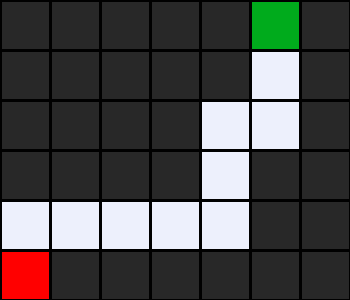


Maze 1 - DFS Solution (Path: 10 steps, Explored: 11):


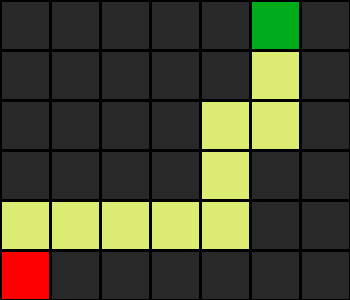

In [163]:
# Step 8b: Visualize maze1 with colors

m1 = Maze("src0/maze1.txt")

# Show unsolved maze
print("Maze 1 - Before solving:")
display(m1.output_image(cell_size=50))

# Solve with DFS and show
m1.solve(use_bfs=False)
print(f"\nMaze 1 - DFS Solution (Path: {len(m1.solution[0])} steps, Explored: {m1.num_explored}):")
display(m1.output_image(show_solution=True, show_explored=True, cell_size=50))

=== Maze 2: DFS vs BFS Comparison ===

DFS - Path: 30 steps, Explored: 194 states
(Yellow = solution path, Orange = explored states)


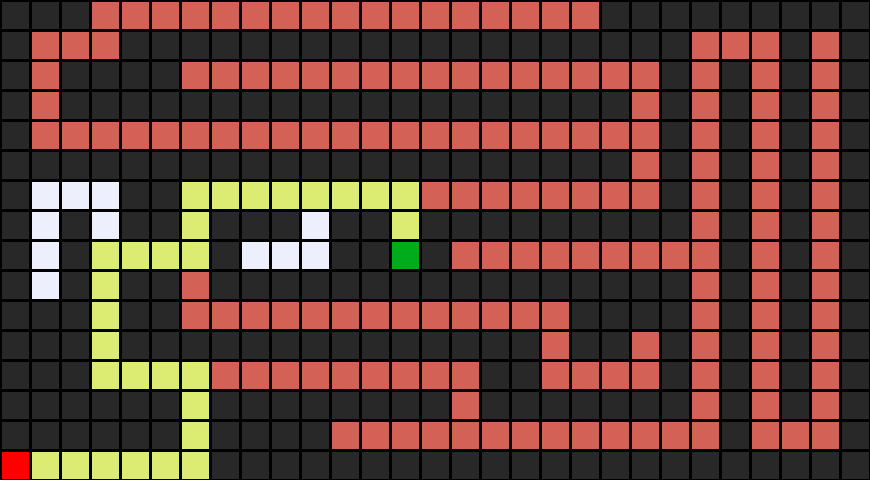


BFS - Path: 30 steps, Explored: 77 states
(Yellow = solution path, Orange = explored states)


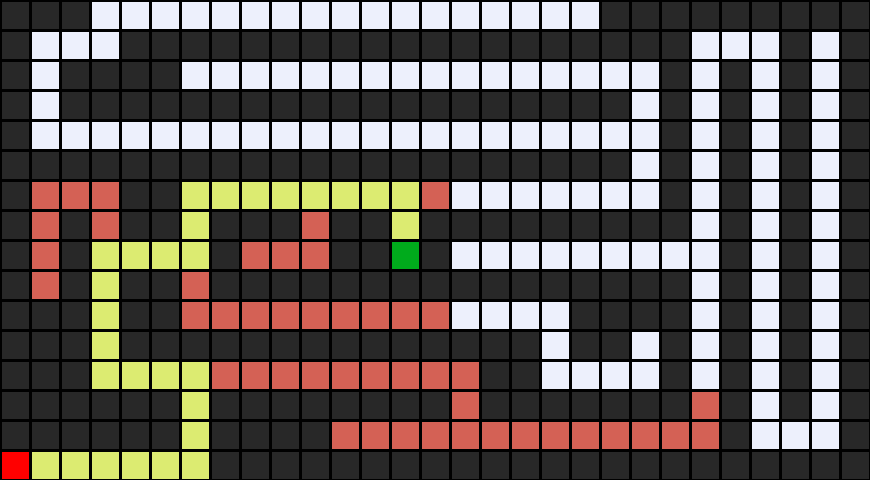


📊 BFS found a path that is 0 steps SHORTER!


In [ ]:
# Step 8c: Compare DFS vs BFS visually on maze2

m2 = Maze("src0/maze2.txt")

# DFS
m2.solve(use_bfs=False)
dfs_path_len = len(m2.solution[0])
dfs_explored = m2.num_explored
dfs_img = m2.output_image(show_solution=True, show_explored=True, cell_size=30)

# BFS
m2.solve(use_bfs=True)
bfs_path_len = len(m2.solution[0])
bfs_explored = m2.num_explored
bfs_img = m2.output_image(show_solution=True, show_explored=True, cell_size=30)

print("=== Maze 2: DFS vs BFS Comparison ===")
print()
print(f"DFS - Path: {dfs_path_len} steps, Explored: {dfs_explored} states")
print("(Yellow = solution path, Orange = explored states)")
display(dfs_img)

print()
print(f"BFS - Path: {bfs_path_len} steps, Explored: {bfs_explored} states")
print("(Yellow = solution path, Orange = explored states)")
display(bfs_img)

print()
print(f" BFS found a path that is {dfs_path_len - bfs_path_len} steps SHORTER!")

=== DSE313 AI Maze ===
Dimensions: 9 x 56

Unsolved maze:


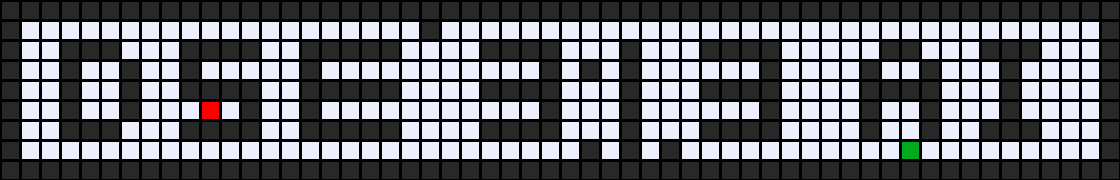


BFS Solution - Path: 51 steps, Explored: 226 states


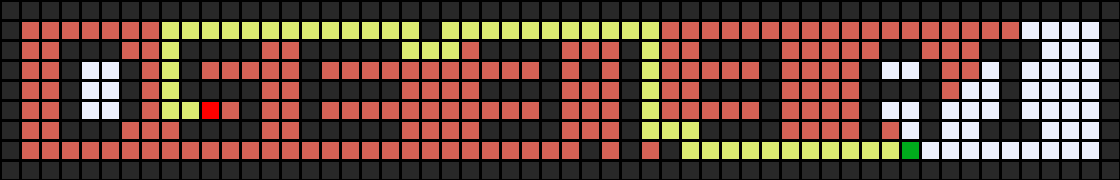


Image saved to: dse313ai_solution.png


In [165]:
# Step 8d: Visualize the DSE313 AI maze

m3 = Maze("src0/dse313ai.txt")

print("=== DSE313 AI Maze ===")
print(f"Dimensions: {m3.height} x {m3.width}")
print()

# Show unsolved
print("Unsolved maze:")
display(m3.output_image(cell_size=20))

# Solve with BFS (shortest path)
m3.solve(use_bfs=True)
print(f"\nBFS Solution - Path: {len(m3.solution[0])} steps, Explored: {m3.num_explored} states")
display(m3.output_image(show_solution=True, show_explored=True, cell_size=20))

# Save to file
m3.output_image(filename="dse313ai_solution.png", show_solution=True, show_explored=True, cell_size=20)
print("\nImage saved to: dse313ai_solution.png")

### Step 8 Summary

We added the `output_image()` method to create colorful visualizations:

**Color Legend:**
| Color | RGB Value | Meaning |
|-------|-----------|---------|
| Red | (255, 0, 0) | Start position (A) |
| Green | (0, 171, 28) | Goal position (B) |
| Dark Gray | (40, 40, 40) | Walls |
| Yellow | (220, 235, 113) | Solution path |
| Orange | (212, 97, 85) | Explored states |
| Light Gray | (237, 240, 252) | Empty cells |

**Method parameters:**
- `filename` - save image to file (optional)
- `show_solution` - highlight solution path in yellow
- `show_explored` - highlight explored states in orange
- `cell_size` - size of each cell in pixels

**Usage:**
```python
m = Maze("maze.txt")
m.solve(use_bfs=True)
img = m.output_image(show_solution=True, show_explored=True)
display(img)  # Show in notebook
m.output_image(filename="solution.png")  # Save to file
```